<a href="https://colab.research.google.com/github/onlygoodman/dacon_shopping_sales_predict/blob/main/project_shop_shell005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

001 - 기본적인 전처리 및 성능확인

002 - 새로운 특성 추가 및 연속형 데이터 -> 대대적인 범주화
특성 다음을 사용
['Tem_mean', 'Fuel_mean', 'Unemp_mean', 'Store_mean', 'Week_mean', 'Month_mean', 'Day_mean']

003 - 001에서 사용한 기본적인 특성 재사용 및 전처리 오류 확인

004 - 이상적인 RMSE score 값의 개선이 되지 않기 때문에 RANSACRegressor 모듈을 활용하여 RMSE값 최소화 시도

005 - Pycaret 사용하여 결과도출시도


In [4]:
import pandas as pd
import numpy as np
import pandas as pd
from itertools import permutations,combinations
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")


import math #차후 factorial 계산 등 수학적인 계산을 위한 import
from numpy import dot
from numpy.linalg import norm

from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.preprocessing import PolynomialFeatures #특성공학을 사용하기 위한 import
from sklearn.preprocessing import StandardScaler #전처리된 데이터들의 scale을 맞춰주기 위한 import
from sklearn.decomposition import PCA #차원 축소 - 주성분의 개수에 따른 최적화 모델 구현을 위한 import


#model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor

from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
# from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score #이후 test.csv 파일의 predict 자료의 score을 매기기 위한 import

In [5]:
# Train dataset은 Label이 존재하지 않음
train_df = pd.read_csv("/content/drive/MyDrive/shopping_sell_dataset/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/shopping_sell_dataset/test.csv")
submit = pd.read_csv("/content/drive/MyDrive/shopping_sell_dataset/sample_submission.csv")

In [6]:
train_df.head()

id  Store        Date  Temperature  Fuel_Price  Promotion1  Promotion2  \
0   1      1  05/02/2010        42.31       2.572         NaN         NaN   
1   2      1  12/02/2010        38.51       2.548         NaN         NaN   
2   3      1  19/02/2010        39.93       2.514         NaN         NaN   
3   4      1  26/02/2010        46.63       2.561         NaN         NaN   
4   5      1  05/03/2010        46.50       2.625         NaN         NaN   

   Promotion3  Promotion4  Promotion5  Unemployment  IsHoliday  Weekly_Sales  
0         NaN         NaN         NaN         8.106      False    1643690.90  
1         NaN         NaN         NaN         8.106       True    1641957.44  
2         NaN         NaN         NaN         8.106      False    1611968.17  
3         NaN         NaN         NaN         8.106      False    1409727.59  
4         NaN         NaN         NaN         8.106      False    1554806.68

In [7]:
test_df.describe()

id     Store  Temperature  Fuel_Price    Promotion1  \
count  180.000000  180.0000   180.000000  180.000000    178.000000   
mean    90.500000   23.0000    61.518056    3.853361   3308.837584   
std     52.105662   13.0234    10.455740    0.274645   3054.767656   
min      1.000000    1.0000    39.380000    3.494000     15.880000   
25%     45.750000   12.0000    54.180000    3.601000    968.205000   
50%     90.500000   23.0000    61.530000    3.789000   2352.585000   
75%    135.250000   34.0000    70.357500    4.027000   5028.902500   
max    180.000000   45.0000    85.180000    4.468000  16670.040000   

       Promotion2  Promotion3   Promotion4    Promotion5  Unemployment  
count   45.000000  161.000000   146.000000    180.000000    180.000000  
mean    64.672000   30.557888  1284.340068   3451.423778      6.953711  
std     68.190071   47.713744  1565.140023   2878.242354      1.593834  
min     -7.010000    0.010000     0.220000    180.070000      3.879000  
25%      7.240000    4.700000   372.817500   1310.800000      6.034000  
50%     53.070000    9.890000   727.930000   2805.300000      6.895000  
75%    101.340000   28.910000  1507.197500   4471.612500      8.000000  
max    364.570000  250.600000  9546.750000  15387.940000     10.199000

In [8]:
train_df.describe()

id        Store  Temperature   Fuel_Price    Promotion1  \
count  6255.000000  6255.000000  6255.000000  6255.000000   2102.000000   
mean   3128.000000    23.000000    60.639199     3.344369   7155.930661   
std    1805.807299    12.988211    18.624094     0.455364   8408.206085   
min       1.000000     1.000000    -2.060000     2.472000      0.270000   
25%    1564.500000    12.000000    47.170000     2.917000   1844.295000   
50%    3128.000000    23.000000    62.720000     3.413000   5221.140000   
75%    4691.500000    34.000000    75.220000     3.722000   9199.242500   
max    6255.000000    45.000000   100.140000     4.308000  88646.760000   

          Promotion2     Promotion3    Promotion4     Promotion5  \
count    1592.000000    1885.000000   1819.000000    2115.000000   
mean     3308.125810    1462.535523   3465.952501    4518.993173   
std      9382.823804    9667.580258   6413.116294    6048.661908   
min      -265.760000     -29.100000      0.410000     135.160000   
25%        39.755000       4.700000    499.895000    1742.305000   
50%       205.410000      24.600000   1532.630000    3226.410000   
75%      1931.005000     104.010000   3640.905000    5444.030000   
max    104519.540000  141630.610000  67474.850000  108519.280000   

       Unemployment  Weekly_Sales  
count   6255.000000  6.255000e+03  
mean       8.029236  1.047619e+06  
std        1.874875  5.654362e+05  
min        4.077000  2.099862e+05  
25%        6.916500  5.538695e+05  
50%        7.906000  9.604761e+05  
75%        8.622000  1.421209e+06  
max       14.313000  3.818686e+06

In [9]:
#date form change
def datefunc(date):
  d, m ,y = date.split("/")
  return "{}/{}/{}".format(y,m,d)

def monthfunc(date):
  d, m, y = date.split("/")
  return int(m)

def dayfunc(date):
  d, m, y = date.split("/")
  return int(d)

#bool data to one hot encoding
def holiday_to_number(isholiday):
    if isholiday == True:
        number = 1
    else:
        number = 0
    return number

#기존 Date의 형식이 옳지 않아 date값 변경
train_df['Date_new']=train_df['Date'].apply(lambda x: datefunc(x))
test_df['Date_new']=test_df['Date'].apply(lambda x: datefunc(x))  

#기존 Date형식에서 월 columns 추가 -> 차후 월별 매출 등급 부여에 사용
train_df['Month'] = train_df['Date'].apply(lambda x: monthfunc(x))
test_df['Month'] = test_df['Date'].apply(lambda x: monthfunc(x))

#기존 Date형식에서 일 columns 추가 -> 차후 일별 매출 등급 부여에 사용
train_df['Day'] = train_df['Date'].apply(lambda x: dayfunc(x))
test_df['Day'] = test_df['Date'].apply(lambda x: dayfunc(x))

# 이 함수를 IsHoliday 칼럼에 적용한 NumberHoliday 칼럼을 만들어줍니다.
train_df['NumberHoliday'] = train_df['IsHoliday'].apply(holiday_to_number)
test_df['NumberHoliday'] = test_df['IsHoliday'].apply(holiday_to_number)

# data.drop(columns=['ID'])[col]
train_df.drop(columns=['IsHoliday'], inplace = True)
test_df.drop(columns=['IsHoliday'], inplace = True)

train_df.head()
# train_df.to_csv("mydata1.csv")

id  Store        Date  Temperature  Fuel_Price  Promotion1  Promotion2  \
0   1      1  05/02/2010        42.31       2.572         NaN         NaN   
1   2      1  12/02/2010        38.51       2.548         NaN         NaN   
2   3      1  19/02/2010        39.93       2.514         NaN         NaN   
3   4      1  26/02/2010        46.63       2.561         NaN         NaN   
4   5      1  05/03/2010        46.50       2.625         NaN         NaN   

   Promotion3  Promotion4  Promotion5  Unemployment  Weekly_Sales    Date_new  \
0         NaN         NaN         NaN         8.106    1643690.90  2010/02/05   
1         NaN         NaN         NaN         8.106    1641957.44  2010/02/12   
2         NaN         NaN         NaN         8.106    1611968.17  2010/02/19   
3         NaN         NaN         NaN         8.106    1409727.59  2010/02/26   
4         NaN         NaN         NaN         8.106    1554806.68  2010/03/05   

   Month  Day  NumberHoliday  
0      2    5              0  
1      2   12              1  
2      2   19              0  
3      2   26              0  
4      3    5              0

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6255 non-null   int64  
 1   Store          6255 non-null   int64  
 2   Date           6255 non-null   object 
 3   Temperature    6255 non-null   float64
 4   Fuel_Price     6255 non-null   float64
 5   Promotion1     2102 non-null   float64
 6   Promotion2     1592 non-null   float64
 7   Promotion3     1885 non-null   float64
 8   Promotion4     1819 non-null   float64
 9   Promotion5     2115 non-null   float64
 10  Unemployment   6255 non-null   float64
 11  Weekly_Sales   6255 non-null   float64
 12  Date_new       6255 non-null   object 
 13  Month          6255 non-null   int64  
 14  Day            6255 non-null   int64  
 15  NumberHoliday  6255 non-null   int64  
dtypes: float64(9), int64(5), object(2)
memory usage: 782.0+ KB


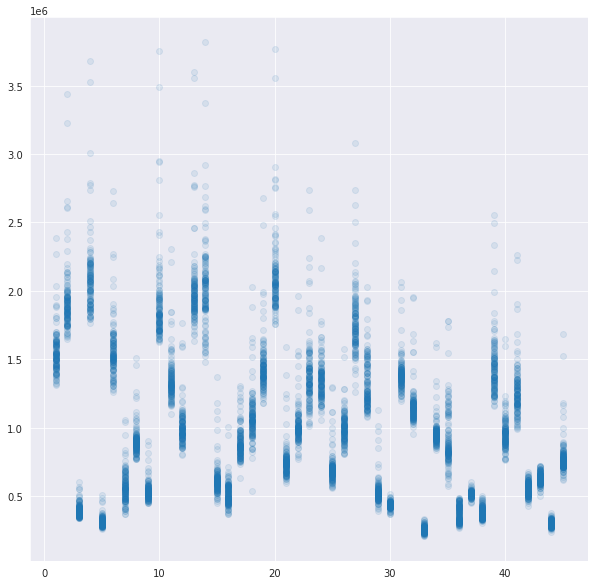

In [11]:
#Store별로 매출액 평균이 유의미한 분포를 갖고 있다. Store별로 outlier 제거 후 평균 

# train_df.plot(kind='line', x=range(len(train_df)), y="Weekly_Sales")
plt.figure(figsize=(10, 10))
plt.scatter(train_df['Store'], train_df['Weekly_Sales'], alpha=0.1)

#stroe name 과 매출액간의 상관관계 시각화

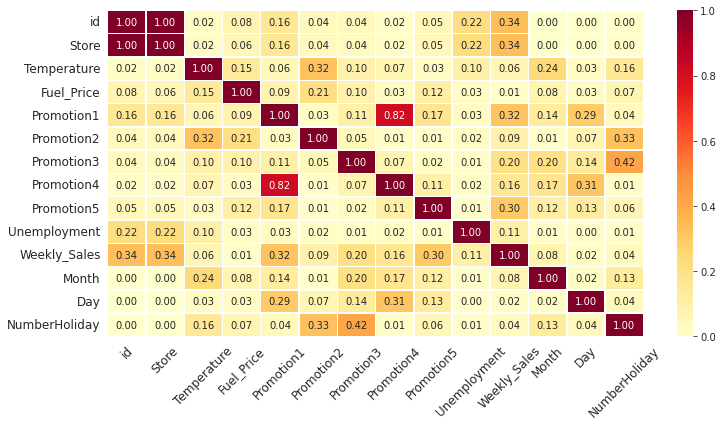

In [12]:
#각 특성 별 상관관계

fig, ax = plt.subplots(figsize=(12,6))

sns.heatmap(train_df.corr().abs(), # 위에서 전처리한 데이터프레임
            annot = True, # 숫자 표시 여부
            ax = ax, # 히트맵을 그릴 격자
            linewidths = 0.4, # 선의 굵기
            linecolor = 'white', # 선의 색깔
            fmt = '.2f', # 소수점 포맷팅 형태
            cmap = 'YlOrRd') # colormap 형태

plt.xticks(rotation=45, size = 12)
plt.yticks(size=12) 
plt.show()

In [13]:
#우선 promotion은 예측에 방해가 되는 요소인것 같아 제거하고 진행
train_df.drop(columns=['Promotion1','Promotion2','Promotion3','Promotion4','Promotion5'], inplace = True)
test_df.drop(columns=['Promotion1','Promotion2','Promotion3','Promotion4','Promotion5'], inplace = True)

train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

#Temperature과 Fuel을 범주형으로 나누어 판매액과 비교
def temfunc(temp):
  if temp<47 and temp>-5:
    return 0

  elif temp>=47 and temp<62:
    return 2

  elif temp>=62 and temp<75:
    return 1

  else:
    return 3

def fuelfunc(fuel):
  if fuel<2.917:
    return 2
  
  elif fuel>=2.917 and fuel<3.413:
    return 0
  
  elif fuel>=3.413:
    return 1

def unemplefunc(employ):
  if employ<6.9 and employ>1.8:
    return 1
  elif employ>=6.9 and employ<7.9:
    return 0
  elif employ>=7.9 and employ>8.6:
    return 1
  else:
    return 0

train_df['Tem_level']=train_df['Temperature'].apply(lambda x : temfunc(x))
test_df['Tem_level']=test_df['Temperature'].apply(lambda x : temfunc(x))

train_df['Fuel_level']=train_df['Fuel_Price'].apply(lambda x : fuelfunc(x))
test_df['Fuel_level']=test_df['Fuel_Price'].apply(lambda x : fuelfunc(x))

train_df['Unemp_level']=train_df['Unemployment'].apply(lambda x : unemplefunc(x))
test_df['Unemp_level']=test_df['Unemployment'].apply(lambda x : unemplefunc(x))

In [14]:
train_df.describe()

id        Store  Temperature   Fuel_Price  Unemployment  \
count  6255.000000  6255.000000  6255.000000  6255.000000   6255.000000   
mean   3128.000000    23.000000    60.639199     3.344369      8.029236   
std    1805.807299    12.988211    18.624094     0.455364      1.874875   
min       1.000000     1.000000    -2.060000     2.472000      4.077000   
25%    1564.500000    12.000000    47.170000     2.917000      6.916500   
50%    3128.000000    23.000000    62.720000     3.413000      7.906000   
75%    4691.500000    34.000000    75.220000     3.722000      8.622000   
max    6255.000000    45.000000   100.140000     4.308000     14.313000   

       Weekly_Sales        Month          Day  NumberHoliday    Tem_level  \
count  6.255000e+03  6255.000000  6255.000000    6255.000000  6255.000000   
mean   1.047619e+06     6.345324    15.683453       0.071942     1.499920   
std    5.654362e+05     3.227195     8.781023       0.258413     1.120909   
min    2.099862e+05     1.000000     1.000000       0.000000     0.000000   
25%    5.538695e+05     4.000000     8.000000       0.000000     1.000000   
50%    9.604761e+05     6.000000    16.000000       0.000000     1.000000   
75%    1.421209e+06     9.000000    23.000000       0.000000     3.000000   
max    3.818686e+06    12.000000    31.000000       1.000000     3.000000   

        Fuel_level  Unemp_level  
count  6255.000000  6255.000000  
mean      0.998721     0.495124  
std       0.706087     0.500016  
min       0.000000     0.000000  
25%       1.000000     0.000000  
50%       1.000000     0.000000  
75%       1.000000     1.000000  
max       2.000000     1.000000

In [15]:
train_df['Store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [16]:
test_df['Store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [17]:
temp_mean=train_df[['Tem_level', 'Weekly_Sales']].groupby(['Tem_level']).mean()
fuel_mean=train_df[['Fuel_level', 'Weekly_Sales']].groupby(['Fuel_level']).mean()
emple_mean=train_df[['Unemp_level', 'Weekly_Sales']].groupby(['Unemp_level']).mean()
store_mean=train_df[['Store', 'Weekly_Sales']].groupby(['Store']).mean()
week_mean=train_df[['NumberHoliday', 'Weekly_Sales']].groupby(['NumberHoliday']).mean()

In [18]:
temp_mean

Weekly_Sales
Tem_level              
0          1.095179e+06
1          1.060037e+06
2          1.047123e+06
3          9.891582e+05

In [19]:
fuel_mean

Weekly_Sales
Fuel_level              
0           1.062881e+06
1           1.047631e+06
2           1.032255e+06

In [20]:
emple_mean

Weekly_Sales
Unemp_level              
0            1.135030e+06
1            9.584867e+05

In [21]:
store_mean.head()

Weekly_Sales
Store              
1      1.555088e+06
2      1.926625e+06
3      4.021757e+05
4      2.093196e+06
5      3.178013e+05

In [22]:
week_mean
# Counter(train_df['NumberHoliday'].values)

Weekly_Sales
NumberHoliday              
0              1.041784e+06
1              1.122888e+06

In [23]:
tm = list(temp_mean['Weekly_Sales'].values)
fm = list(fuel_mean['Weekly_Sales'].values)
em = list(emple_mean['Weekly_Sales'].values)
sm = list(store_mean['Weekly_Sales'].values)
wm = list(week_mean['Weekly_Sales'].values)

In [24]:
# iris["new_columns"] = iris["sepal_length"].apply(lambda x : func(x))

train_df['Tem_mean']= train_df['Tem_level'].apply(lambda x: tm[x])
train_df['Fuel_mean']= train_df['Fuel_level'].apply(lambda x: fm[x])
train_df['Unemp_mean']= train_df['Unemp_level'].apply(lambda x: em[x])
train_df['Store_mean']= train_df['Store'].apply(lambda x : sm[x-1])
train_df['Week_mean']= train_df['NumberHoliday'].apply(lambda x : wm[x])


test_df['Tem_mean']= test_df['Tem_level'].apply(lambda x: tm[x])
test_df['Fuel_mean']= test_df['Fuel_level'].apply(lambda x: fm[x])
test_df['Unemp_mean']= test_df['Unemp_level'].apply(lambda x: em[x])
test_df['Store_mean']= test_df['Store'].apply(lambda x : sm[x-1])
test_df['Week_mean']= test_df['NumberHoliday'].apply(lambda x : wm[x])

In [25]:
train_df.columns

Index(['id', 'Store', 'Date', 'Temperature', 'Fuel_Price', 'Unemployment',
       'Weekly_Sales', 'Date_new', 'Month', 'Day', 'NumberHoliday',
       'Tem_level', 'Fuel_level', 'Unemp_level', 'Tem_mean', 'Fuel_mean',
       'Unemp_mean', 'Store_mean', 'Week_mean'],
      dtype='object')

In [26]:
month_mean=train_df[['Month', 'Weekly_Sales']].groupby(['Month']).mean()/10**5-train_df['Weekly_Sales'].mean()/10**5
day_mean=train_df[['Day', 'Weekly_Sales']].groupby(['Day']).mean()/10**5-train_df['Weekly_Sales'].mean()/10**5

In [27]:
train_df.head(3)

id  Store        Date  Temperature  Fuel_Price  Unemployment  Weekly_Sales  \
0   1      1  05/02/2010        42.31       2.572         8.106    1643690.90   
1   2      1  12/02/2010        38.51       2.548         8.106    1641957.44   
2   3      1  19/02/2010        39.93       2.514         8.106    1611968.17   

     Date_new  Month  Day  NumberHoliday  Tem_level  Fuel_level  Unemp_level  \
0  2010/02/05      2    5              0          0           2            0   
1  2010/02/12      2   12              1          0           2            0   
2  2010/02/19      2   19              0          0           2            0   

       Tem_mean     Fuel_mean    Unemp_mean    Store_mean     Week_mean  
0  1.095179e+06  1.032255e+06  1.135030e+06  1.555088e+06  1.041784e+06  
1  1.095179e+06  1.032255e+06  1.135030e+06  1.555088e+06  1.122888e+06  
2  1.095179e+06  1.032255e+06  1.135030e+06  1.555088e+06  1.041784e+06

In [28]:
for col in  ['Tem_level','Fuel_level','Unemp_level']:
  train_df = pd.get_dummies(train_df, columns = [col])
  test_df = pd.get_dummies(test_df, columns = [col]) 

def fuelfunc2(x):
  return 0


test_df['Fuel_level_0']= test_df['Day'].apply(lambda x: fuelfunc2(x))
test_df['Fuel_level_2']= test_df['Day'].apply(lambda x: fuelfunc2(x)) 

In [29]:
train_df

id  Store        Date  Temperature  Fuel_Price  Unemployment  \
0        1      1  05/02/2010        42.31       2.572         8.106   
1        2      1  12/02/2010        38.51       2.548         8.106   
2        3      1  19/02/2010        39.93       2.514         8.106   
3        4      1  26/02/2010        46.63       2.561         8.106   
4        5      1  05/03/2010        46.50       2.625         8.106   
...    ...    ...         ...          ...         ...           ...   
6250  6251     45  31/08/2012        75.09       3.867         8.684   
6251  6252     45  07/09/2012        75.70       3.911         8.684   
6252  6253     45  14/09/2012        67.87       3.948         8.684   
6253  6254     45  21/09/2012        65.32       4.038         8.684   
6254  6255     45  28/09/2012        64.88       3.997         8.684   

      Weekly_Sales    Date_new  Month  Day  ...     Week_mean  Tem_level_0  \
0       1643690.90  2010/02/05      2    5  ...  1.041784e+06            1   
1       1641957.44  2010/02/12      2   12  ...  1.122888e+06            1   
2       1611968.17  2010/02/19      2   19  ...  1.041784e+06            1   
3       1409727.59  2010/02/26      2   26  ...  1.041784e+06            1   
4       1554806.68  2010/03/05      3    5  ...  1.041784e+06            1   
...            ...         ...    ...  ...  ...           ...          ...   
6250     734297.87  2012/08/31      8   31  ...  1.041784e+06            0   
6251     766512.66  2012/09/07      9    7  ...  1.122888e+06            0   
6252     702238.27  2012/09/14      9   14  ...  1.041784e+06            0   
6253     723086.20  2012/09/21      9   21  ...  1.041784e+06            0   
6254     713173.95  2012/09/28      9   28  ...  1.041784e+06            0   

      Tem_level_1  Tem_level_2  Tem_level_3  Fuel_level_0  Fuel_level_1  \
0               0            0            0             0             0   
1               0            0            0             0             0   
2               0            0            0             0             0   
3               0            0            0             0             0   
4               0            0            0             0             0   
...           ...          ...          ...           ...           ...   
6250            0            0            1             0             1   
6251            0            0            1             0             1   
6252            1            0            0             0             1   
6253            1            0            0             0             1   
6254            1            0            0             0             1   

      Fuel_level_2  Unemp_level_0  Unemp_level_1  
0                1              1              0  
1                1              1              0  
2                1              1              0  
3                1              1              0  
4                1              1              0  
...            ...            ...            ...  
6250             0              0              1  
6251             0              0              1  
6252             0              0              1  
6253             0              0              1  
6254             0              0              1  

[6255 rows x 25 columns]

In [30]:
test_df['Fuel_level_1'].describe()

count    180.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: Fuel_level_1, dtype: float64

In [31]:
test_df

id  Store        Date  Temperature  Fuel_Price  Unemployment  \
0      1      1  05/10/2012        68.55       3.617         6.573   
1      2      1  12/10/2012        62.99       3.601         6.573   
2      3      1  19/10/2012        67.97       3.594         6.573   
3      4      1  26/10/2012        69.16       3.506         6.573   
4      5      2  05/10/2012        70.27       3.617         6.170   
..   ...    ...         ...          ...         ...           ...   
175  176     44  26/10/2012        46.97       3.755         5.217   
176  177     45  05/10/2012        64.89       3.985         8.667   
177  178     45  12/10/2012        54.47       4.000         8.667   
178  179     45  19/10/2012        56.47       3.969         8.667   
179  180     45  26/10/2012        58.85       3.882         8.667   

       Date_new  Month  Day  NumberHoliday  ...     Week_mean  Tem_level_0  \
0    2012/10/05     10    5              0  ...  1.041784e+06            0   
1    2012/10/12     10   12              0  ...  1.041784e+06            0   
2    2012/10/19     10   19              0  ...  1.041784e+06            0   
3    2012/10/26     10   26              0  ...  1.041784e+06            0   
4    2012/10/05     10    5              0  ...  1.041784e+06            0   
..          ...    ...  ...            ...  ...           ...          ...   
175  2012/10/26     10   26              0  ...  1.041784e+06            1   
176  2012/10/05     10    5              0  ...  1.041784e+06            0   
177  2012/10/12     10   12              0  ...  1.041784e+06            0   
178  2012/10/19     10   19              0  ...  1.041784e+06            0   
179  2012/10/26     10   26              0  ...  1.041784e+06            0   

     Tem_level_1  Tem_level_2  Tem_level_3  Fuel_level_1  Unemp_level_0  \
0              1            0            0             1              0   
1              1            0            0             1              0   
2              1            0            0             1              0   
3              1            0            0             1              0   
4              1            0            0             1              0   
..           ...          ...          ...           ...            ...   
175            0            0            0             1              0   
176            1            0            0             1              0   
177            0            1            0             1              0   
178            0            1            0             1              0   
179            0            1            0             1              0   

     Unemp_level_1  Fuel_level_0  Fuel_level_2  
0                1             0             0  
1                1             0             0  
2                1             0             0  
3                1             0             0  
4                1             0             0  
..             ...           ...           ...  
175              1             0             0  
176              1             0             0  
177              1             0             0  
178              1             0             0  
179              1             0             0  

[180 rows x 24 columns]

In [32]:
month_mean.head(3)

Weekly_Sales
Month              
1         -1.237345
2          0.055807
3         -0.343098

In [33]:
day_mean.head(3)

Weekly_Sales
Day              
1       -0.389578
2        0.233566
3        0.165889

In [34]:
mm = list(month_mean['Weekly_Sales'].values)
dm = list(day_mean['Weekly_Sales'].values)

In [35]:
print(mm)
print(dm)
len(dm)

[-1.2373452245023984, 0.05580723318278835, -0.34309840854085927, -0.20857510366906418, -0.15905051681721183, 0.16705519077538078, -0.1587149087484292, 0.0039837716300823445, -0.5828372464895768, -0.5892004376196827, 0.9964682899420474, 2.34244559966427]
[-0.38957761144684255, 0.23356617255315903, 0.1658886983309351, 0.15056482677538163, 0.10267924299760267, 0.40281891121982305, -0.09725857366906432, -0.003919816446842361, 0.41579366855315847, 0.474198677442045, -0.023294620335731153, -0.10749939478017545, -0.4022958394468432, -0.7759342275579542, -0.3622550597801748, 0.2886416005531576, 0.6305024681087144, -0.05514824478017566, -0.18125183700239766, -0.5063853727801746, -0.7012875914468406, -0.21585418589128658, 0.8275174467753796, 1.1412694734420459, 0.5503498787753784, 0.7093916991087141, -0.7494295821135104, -0.6457420714468416, -0.6198990642246205, -0.616339893669064, -0.7437286903357307]


31

In [36]:
train_df['Month_mean']= train_df['Month'].apply(lambda x : mm[x-1])
train_df['Day_mean']= train_df['Day'].apply(lambda x : dm[x-1])


test_df['Month_mean']= test_df['Month'].apply(lambda x: mm[x-1])
test_df['Day_mean']= test_df['Day'].apply(lambda x: dm[x-1])

In [37]:
#전처리확인
train_df.head()

id  Store        Date  Temperature  Fuel_Price  Unemployment  Weekly_Sales  \
0   1      1  05/02/2010        42.31       2.572         8.106    1643690.90   
1   2      1  12/02/2010        38.51       2.548         8.106    1641957.44   
2   3      1  19/02/2010        39.93       2.514         8.106    1611968.17   
3   4      1  26/02/2010        46.63       2.561         8.106    1409727.59   
4   5      1  05/03/2010        46.50       2.625         8.106    1554806.68   

     Date_new  Month  Day  ...  Tem_level_1  Tem_level_2  Tem_level_3  \
0  2010/02/05      2    5  ...            0            0            0   
1  2010/02/12      2   12  ...            0            0            0   
2  2010/02/19      2   19  ...            0            0            0   
3  2010/02/26      2   26  ...            0            0            0   
4  2010/03/05      3    5  ...            0            0            0   

   Fuel_level_0  Fuel_level_1  Fuel_level_2  Unemp_level_0  Unemp_level_1  \
0             0             0             1              1              0   
1             0             0             1              1              0   
2             0             0             1              1              0   
3             0             0             1              1              0   
4             0             0             1              1              0   

   Month_mean  Day_mean  
0    0.055807  0.102679  
1    0.055807 -0.107499  
2    0.055807 -0.181252  
3    0.055807  0.709392  
4   -0.343098  0.102679  

[5 rows x 27 columns]

In [38]:
#전처리확인
test_df.head()

id  Store        Date  Temperature  Fuel_Price  Unemployment    Date_new  \
0   1      1  05/10/2012        68.55       3.617         6.573  2012/10/05   
1   2      1  12/10/2012        62.99       3.601         6.573  2012/10/12   
2   3      1  19/10/2012        67.97       3.594         6.573  2012/10/19   
3   4      1  26/10/2012        69.16       3.506         6.573  2012/10/26   
4   5      2  05/10/2012        70.27       3.617         6.170  2012/10/05   

   Month  Day  NumberHoliday  ...  Tem_level_1  Tem_level_2  Tem_level_3  \
0     10    5              0  ...            1            0            0   
1     10   12              0  ...            1            0            0   
2     10   19              0  ...            1            0            0   
3     10   26              0  ...            1            0            0   
4     10    5              0  ...            1            0            0   

   Fuel_level_1  Unemp_level_0  Unemp_level_1  Fuel_level_0  Fuel_level_2  \
0             1              0              1             0             0   
1             1              0              1             0             0   
2             1              0              1             0             0   
3             1              0              1             0             0   
4             1              0              1             0             0   

   Month_mean  Day_mean  
0     -0.5892  0.102679  
1     -0.5892 -0.107499  
2     -0.5892 -0.181252  
3     -0.5892  0.709392  
4     -0.5892  0.102679  

[5 rows x 26 columns]

In [39]:
train_columns_list = list(train_df.columns)
test_columns_list = list(test_df.columns)
print(train_columns_list)
print(test_columns_list)

train_df.drop(columns=['id','Store','Temperature', 'Fuel_Price','Unemployment', 'Date','Date_new','Month','Day','Weekly_Sales'], inplace=True)
test_df.drop(columns=['id','Store','Temperature', 'Fuel_Price','Unemployment', 'Date','Date_new','Month','Day'], inplace=True)


['id', 'Store', 'Date', 'Temperature', 'Fuel_Price', 'Unemployment', 'Weekly_Sales', 'Date_new', 'Month', 'Day', 'NumberHoliday', 'Tem_mean', 'Fuel_mean', 'Unemp_mean', 'Store_mean', 'Week_mean', 'Tem_level_0', 'Tem_level_1', 'Tem_level_2', 'Tem_level_3', 'Fuel_level_0', 'Fuel_level_1', 'Fuel_level_2', 'Unemp_level_0', 'Unemp_level_1', 'Month_mean', 'Day_mean']
['id', 'Store', 'Date', 'Temperature', 'Fuel_Price', 'Unemployment', 'Date_new', 'Month', 'Day', 'NumberHoliday', 'Tem_mean', 'Fuel_mean', 'Unemp_mean', 'Store_mean', 'Week_mean', 'Tem_level_0', 'Tem_level_1', 'Tem_level_2', 'Tem_level_3', 'Fuel_level_1', 'Unemp_level_0', 'Unemp_level_1', 'Fuel_level_0', 'Fuel_level_2', 'Month_mean', 'Day_mean']


In [40]:
train_columns_list = list(train_df.columns)
test_columns_list = list(test_df.columns)
print(train_columns_list)
print(test_columns_list)

['NumberHoliday', 'Tem_mean', 'Fuel_mean', 'Unemp_mean', 'Store_mean', 'Week_mean', 'Tem_level_0', 'Tem_level_1', 'Tem_level_2', 'Tem_level_3', 'Fuel_level_0', 'Fuel_level_1', 'Fuel_level_2', 'Unemp_level_0', 'Unemp_level_1', 'Month_mean', 'Day_mean']
['NumberHoliday', 'Tem_mean', 'Fuel_mean', 'Unemp_mean', 'Store_mean', 'Week_mean', 'Tem_level_0', 'Tem_level_1', 'Tem_level_2', 'Tem_level_3', 'Fuel_level_1', 'Unemp_level_0', 'Unemp_level_1', 'Fuel_level_0', 'Fuel_level_2', 'Month_mean', 'Day_mean']


In [55]:
!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.23.2 --user

Found existing installation: sklearn 0.0
Uninstalling sklearn-0.0:
  Successfully uninstalled sklearn-0.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=ce6bcd1ef82c357c484961e3456ff26e327cddef397f885da6675b58ad6d4e6e
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import sklearn
sklearn.__version__

'0.23.2'

In [2]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [3]:
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
!pip install Jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
from datetime import datetime
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from pycaret.regression import *
model = setup(train_df, target = 'Weekly_Sales', 
              fold_shuffle=True,
              fold=15, 
              session_id=530,
              remove_multicollinearity = True,
              normalize= True,
              n_jobs = -1,
              silent = True,
              combine_rare_levels = True,
              ignore_low_variance = True )

ImportError: ignored

In [48]:
top5_model = compare_models(round=4, n_select = 5, sort='RMSE')

NameError: ignored

In [ ]:
stacker = stack_models(top5_model[:4], optimize = 'RMSE')

In [ ]:
prediction = predict_model(stacker, data=test_df)
pred = np.expm1(prediction['Label'])

# 예측된 값을 정답파일과 병합
submit['Weekly_Sales'] = pred

# 정답파일 데이터프레임 확인
submit.head()
submit.to_csv('sub004_model_Pycret.csv',index = False)

# submit = pd.read_csv("/content/drive/MyDrive/shopping_sell_dataset/sample_submission.csv")
# temp = pd.read_csv('data/sample_submission.csv')
# temp['Weekly_Sales'] = pred.reset_index()['Label']

# submission = pd.DataFrame({
#         "id" : temp['id'],
#         "Weekly_Sales" : temp['Weekly_Sales']
# })
# submission.to_csv('submit1.csv', index = False)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
#필요없는 칼럼 제거 및 데이터 준비
target = train_df["Weekly_Sales"].to_numpy()

# train_df.drop(columns=train_columns_list[:14], inplace = True)
# test_df.drop(columns=test_columns_list[:13], inplace = True)

train_columns_list = list(train_df.columns)
test_columns_list = list(test_df.columns)

print(train_columns_list)
print(test_columns_list)

['NumberHoliday', 'Tem_mean', 'Fuel_mean', 'Unemp_mean', 'Store_mean', 'Week_mean', 'Tem_level_0', 'Tem_level_1', 'Tem_level_2', 'Tem_level_3', 'Fuel_level_0', 'Fuel_level_1', 'Fuel_level_2', 'Unemp_level_0', 'Unemp_level_1', 'Month_mean', 'Day_mean']
['NumberHoliday', 'Tem_mean', 'Fuel_mean', 'Unemp_mean', 'Store_mean', 'Week_mean', 'Tem_level_0', 'Tem_level_1', 'Tem_level_2', 'Tem_level_3', 'Fuel_level_1', 'Unemp_level_0', 'Unemp_level_1', 'Fuel_level_0', 'Fuel_level_2', 'Month_mean', 'Day_mean']


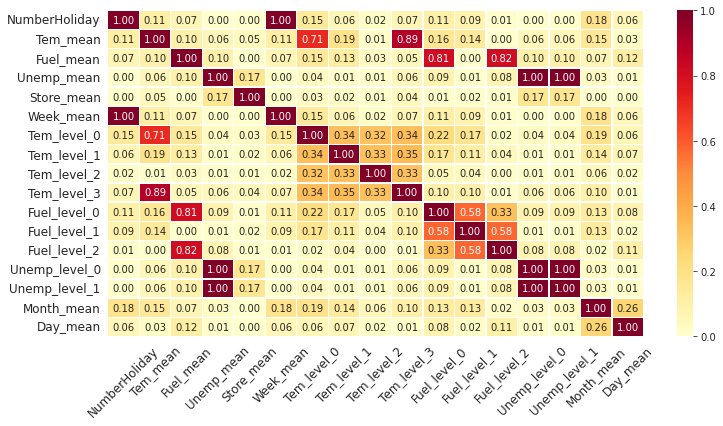

In [ ]:
#각 특성 별 상관관계

fig, ax = plt.subplots(figsize=(12,6))

sns.heatmap(train_df.corr().abs(), # 위에서 전처리한 데이터프레임
            annot = True, # 숫자 표시 여부
            ax = ax, # 히트맵을 그릴 격자
            linewidths = 0.4, # 선의 굵기
            linecolor = 'white', # 선의 색깔
            fmt = '.2f', # 소수점 포맷팅 형태
            cmap = 'YlOrRd') # colormap 형태

plt.xticks(rotation=45, size = 12)
plt.yticks(size=12) 
plt.show()

In [ ]:
train_df.describe()

NumberHoliday      Tem_mean     Fuel_mean    Unemp_mean    Store_mean  \
count    6255.000000  6.255000e+03  6.255000e+03  6.255000e+03  6.255000e+03   
mean        0.071942  1.047619e+06  1.047619e+06  1.047619e+06  1.047619e+06   
std         0.258413  3.837539e+04  1.081250e+04  8.827436e+04  5.411910e+05   
min         0.000000  9.891582e+05  1.032255e+06  9.584867e+05  2.596752e+05   
25%         0.000000  9.891582e+05  1.047631e+06  9.584867e+05  5.561442e+05   
50%         0.000000  1.060037e+06  1.047631e+06  1.135030e+06  9.669910e+05   
75%         0.000000  1.060037e+06  1.047631e+06  1.135030e+06  1.396622e+06   
max         1.000000  1.095179e+06  1.062881e+06  1.135030e+06  2.107607e+06   

          Week_mean  Tem_level_0  Tem_level_1  Tem_level_2  Tem_level_3  \
count  6.255000e+03  6255.000000  6255.000000  6255.000000  6255.000000   
mean   1.047619e+06     0.248281     0.258353     0.238529     0.254836   
std    2.095825e+04     0.432050     0.437764     0.426218     0.435804   
min    1.041784e+06     0.000000     0.000000     0.000000     0.000000   
25%    1.041784e+06     0.000000     0.000000     0.000000     0.000000   
50%    1.041784e+06     0.000000     0.000000     0.000000     0.000000   
75%    1.041784e+06     0.000000     1.000000     0.000000     1.000000   
max    1.122888e+06     1.000000     1.000000     1.000000     1.000000   

       Fuel_level_0  Fuel_level_1  Fuel_level_2  Unemp_level_0  Unemp_level_1  \
count   6255.000000   6255.000000   6255.000000    6255.000000    6255.000000   
mean       0.249880      0.501519      0.248601       0.504876       0.495124   
std        0.432978      0.500038      0.432237       0.500016       0.500016   
min        0.000000      0.000000      0.000000       0.000000       0.000000   
25%        0.000000      0.000000      0.000000       0.000000       0.000000   
50%        0.000000      1.000000      0.000000       1.000000       0.000000   
75%        0.000000      1.000000      0.000000       1.000000       1.000000   
max        1.000000      1.000000      1.000000       1.000000       1.000000   

         Month_mean      Day_mean  
count  6.255000e+03  6.255000e+03  
mean   7.923318e-16  2.811500e-16  
std    7.857201e-01  5.108698e-01  
min   -1.237345e+00 -7.759342e-01  
25%   -3.430984e-01 -4.022958e-01  
50%   -1.587149e-01 -2.329462e-02  
75%    5.580723e-02  4.028189e-01  
max    2.342446e+00  1.141269e+00

In [ ]:
train = train_df[train_columns_list].to_numpy()
sub_input = test_df[test_columns_list].to_numpy()
train_input, test_input, train_target, test_target = train_test_split(train, target, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_input

array([[ 0.00000000e+00,  9.89158162e+05,  1.04763094e+06, ...,
         1.00000000e+00, -5.82837246e-01, -6.45742071e-01],
       [ 0.00000000e+00,  1.09517859e+06,  1.06288113e+06, ...,
         1.00000000e+00,  9.96468290e-01, -1.07499395e-01],
       [ 0.00000000e+00,  1.04712278e+06,  1.03225457e+06, ...,
         0.00000000e+00, -1.59050517e-01, -6.45742071e-01],
       ...,
       [ 1.00000000e+00,  9.89158162e+05,  1.04763094e+06, ...,
         1.00000000e+00, -5.82837246e-01,  4.15793669e-01],
       [ 0.00000000e+00,  1.06003691e+06,  1.04763094e+06, ...,
         0.00000000e+00, -3.43098409e-01,  2.33566173e-01],
       [ 0.00000000e+00,  1.04712278e+06,  1.03225457e+06, ...,
         1.00000000e+00,  3.98377163e-03,  4.02818911e-01]])

In [ ]:
sub_input

array([[ 0.00000000e+00,  1.06003691e+06,  1.04763094e+06, ...,
         0.00000000e+00, -5.89200438e-01,  1.02679243e-01],
       [ 0.00000000e+00,  1.06003691e+06,  1.04763094e+06, ...,
         0.00000000e+00, -5.89200438e-01, -1.07499395e-01],
       [ 0.00000000e+00,  1.06003691e+06,  1.04763094e+06, ...,
         0.00000000e+00, -5.89200438e-01, -1.81251837e-01],
       ...,
       [ 0.00000000e+00,  1.04712278e+06,  1.04763094e+06, ...,
         0.00000000e+00, -5.89200438e-01, -1.07499395e-01],
       [ 0.00000000e+00,  1.04712278e+06,  1.04763094e+06, ...,
         0.00000000e+00, -5.89200438e-01, -1.81251837e-01],
       [ 0.00000000e+00,  1.04712278e+06,  1.04763094e+06, ...,
         0.00000000e+00, -5.89200438e-01,  7.09391699e-01]])

In [ ]:
len(train_input[0])

17

# 데이터 준비 및 훈련 파트

In [ ]:
def rmse(array_target, array_pred):
  return mean_squared_error(array_target, array_pred)**0.5

minscore=1000000000
mx, mn =0,0
poly_dim = 2
x = math.factorial(14+poly_dim)/(math.factorial(14)*math.factorial(poly_dim))

for j in range(int(x), int(x)//2, -1):
  train = train_df[[i for i in train_columns_list if "Fuel_level" not in i]].to_numpy()
  sub_input = test_df[[i for i in train_columns_list if "Fuel_level" not in i]].to_numpy()
  train_input, test_input, train_target, test_target = train_test_split(train, target, test_size=0.2, shuffle=True, random_state=42)

  d=2

  poly = PolynomialFeatures(degree=d)
  poly.fit(train_input)
  train_input = poly.transform(train_input)
  test_input = poly.transform(test_input)
  sub_input = poly.transform(sub_input) 


  ss = StandardScaler()
  ss.fit(train_input)
  train_scaled = ss.transform(train_input)
  test_scaled = ss.transform(test_input)
  sub_scaled =ss.transform(sub_input)


  pca = PCA(n_components = j)
  pca.fit(train_scaled)
  train_pca = pca.transform(train_scaled)
  test_pca = pca.transform(test_scaled) 
  sub_pca = pca.transform(sub_scaled) 

  lr = LinearRegression()
  lr.fit(train_pca, train_target)
  # print(lr.score(test_input, test_target))
  # print(lr.score(train_input, train_target))
  
  test_pred = lr.predict(test_pca)
  score = rmse(test_target, test_pred)
  print(x,"개의 성분을","{:0>3}개로 줄인 \t rmse score :".format(j), score)
  
  if score<minscore:
    minscore=score
    mx,mn = x,j

print("mx,mn,minscore is ", mx, mn, minscore)
# ransac = RANSACRegressor()
# ransac.fit(train_input, train_target)


# ransac_pred = lr.predict(test_input)
# print(rmse(test_target, ransac_pred))




120.0 개의 성분을 120개로 줄인 	 rmse score : 109230.0519783972
120.0 개의 성분을 119개로 줄인 	 rmse score : 109263.0880429056
120.0 개의 성분을 118개로 줄인 	 rmse score : 109362.7363475052
120.0 개의 성분을 117개로 줄인 	 rmse score : 109459.74281219368
120.0 개의 성분을 116개로 줄인 	 rmse score : 109309.66946770133
120.0 개의 성분을 115개로 줄인 	 rmse score : 109719.824340106
120.0 개의 성분을 114개로 줄인 	 rmse score : 109511.43181067058
120.0 개의 성분을 113개로 줄인 	 rmse score : 109247.856286002
120.0 개의 성분을 112개로 줄인 	 rmse score : 109288.3466929771
120.0 개의 성분을 111개로 줄인 	 rmse score : 109566.10325394747
120.0 개의 성분을 110개로 줄인 	 rmse score : 109232.32871633637
120.0 개의 성분을 109개로 줄인 	 rmse score : 109151.3128475535
120.0 개의 성분을 108개로 줄인 	 rmse score : 109115.96877632709
120.0 개의 성분을 107개로 줄인 	 rmse score : 109460.70635690447
120.0 개의 성분을 106개로 줄인 	 rmse score : 109000.96205392784
120.0 개의 성분을 105개로 줄인 	 rmse score : 109202.03443691872
120.0 개의 성분을 104개로 줄인 	 rmse score : 109347.98234636444
120.0 개의 성분을 103개로 줄인 	 rmse score : 109519.6240085618
12

In [ ]:
# ss = StandardScaler()
# ss.fit(train_input)
# train_input = ss.transform(train_input)
# test_input = ss.transform(test_input)
# sub_input =ss.transform(sub_input)

poly_dim = 1
x = math.factorial(14+poly_dim)/(math.factorial(14)*math.factorial(poly_dim))

train = train_df[[i for i in train_columns_list if "Fuel_level" not in i]].to_numpy()
sub_input = test_df[[i for i in train_columns_list if "Fuel_level" not in i]].to_numpy()
train_input, test_input, train_target, test_target = train_test_split(train, target, test_size=0.2, shuffle=True, random_state=42)

d=1

poly = PolynomialFeatures(degree=d)
poly.fit(train_input)
train_input = poly.transform(train_input)
test_input = poly.transform(test_input)
sub_input = poly.transform(sub_input) 


ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)
sub_scaled =ss.transform(sub_input)


pca = PCA(n_components = 14)
pca.fit(train_scaled)
train_pca = pca.transform(train_scaled)
test_pca = pca.transform(test_scaled) 
sub_pca = pca.transform(sub_scaled) 

lr = LinearRegression()
lr.fit(train_pca, train_target)

print(lr.score(test_pca, test_target))
print(lr.score(train_pca, train_target))
RMSE = mean_squared_error(lr.predict(test_pca), test_target)**0.5
def rmse(array_target, array_pred):
  return mean_squared_error(array_target, array_pred)**0.5

test_pred = lr.predict(test_pca)

print(rmse(test_target, test_pred))

# 예측된 값을 정답파일과 병합
prediction = lr.predict(sub_pca)
submit['Weekly_Sales'] = prediction

# 정답파일 데이터프레임 확인
submit.head()
submit.to_csv('sub004_model_lr_0716_final_d1ncom14.csv',index = False)

0.93452816165217
0.9406353504137013
147833.75910169075


In [ ]:
[i for i in train_columns_list if "Fuel_level" not in i]

In [ ]:
len(train_input[0])

In [ ]:
test_df.describe()

In [ ]:
target

In [ ]:
train_df.describe()

In [ ]:
sub_input.shape

In [ ]:
submit.head()

In [ ]:
# 예측된 값을 정답파일과 병합
prediction = lr.predict(sub_input)
submit['Weekly_Sales'] = prediction

# 정답파일 데이터프레임 확인
submit.head()
submit.to_csv('sub003_model_lr_0715_final.csv',index = False)

In [ ]:
prediction

In [ ]:
lr.predict(test_input)

In [ ]:
train_df.head(1)

In [ ]:
for i in train_input:
  print(i)
  break

In [ ]:
for i in sub_input:
  print(i)
  break

id : 샘플 아이디

Store : 쇼핑몰 지점

Date : 주 단위(Weekly) 날짜

Temperature : 해당 쇼핑몰 주변 기온

Fuel_Price : 해당 쇼핑몰 주변 연료 가격

Promotion 1~5 : 해당 쇼핑몰의 비식별화된 프로모션 정보

Unemployment : 해당 쇼핑몰 지역의 실업률

IsHoliday : 해당 기간의 공휴일 포함 여부

Weekly_Sales : 주간 매출액 (목표 예측값)


In [ ]:
numlist = []
while True:
    num = int(input())
    if num == -1:
        break
    numlist.append(num)

def getMyDivisor(n):

    divisorsList = []

    for i in range(1, int(n**(1/2)) + 1):
        if (n % i == 0):
            divisorsList.append(i) 
            if ( (i**2) != n) : 
                divisorsList.append(n // i)

    divisorsList.sort()
    
    return divisorsList

for x in numlist:
    dlist = getMyDivisor(x)
    dlist = dlist[0:len(dlist)-1]
    
    if sum(dlist)!=x:
        print("{} is NOT perfect.".format(x))
    else:
        print("{} = {}".format(x, " + ".join(list(map(str, dlist)))))
    
    

In [ ]:
def getMyDivisor(n):

    divisorsList = []

    for i in range(1, int(n**(1/2)) + 1):
        if (n % i == 0):
            divisorsList.append(i) 
            if ( (i**2) != n) : 
                divisorsList.append(n // i)

    divisorsList.sort()
    
    return divisorsList

import math

def solution(number):
    numbers = [True] * (number + 1)
    answer = 0

    for num in range(2,int(math.sqrt(number))+1):
        if numbers[num] == False:
            continue;

        for i in range(num+num,number+1,num):
            numbers[i] = False

    for i in range(2,number+1):
        if numbers[i] == True:
            answer+=1

    return answer

In [ ]:
x, y, z = map(int, input().split())

def cal(x, y):
  if y==1:
    return x%z
  else:
    q=cal(x, y//2)

    if y%2 == 0:
      return q*q%z
    else:
      return q*q*x%z

print(cal(x,y))

10 11 12
4
